# Model Training and saving




# Bankruptcy Prediction Model  
''A Machine Learning-Driven Approach to Support Entrepreneurs in Decision-Making And Foster Entrepreneurial Resilience Rwanda''




# The Dataset
> ***Brief Description:***

This project aims to develop an ML-driven bankruptcy prediction model that can enable entrepreneurs to proactively identify and mitigate financial risks.


The dataset used in this project includes various financial ratios and metrics that serve as features to predict the likelihood of bankruptcy.


# Random Forest Model Impemantation Using Skit-learn

In [1]:
#Importing the necessary libraries
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pickle
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, f1_score
from imblearn.over_sampling import SMOTE
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# Loading the data
df = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/Data/bankruptcy_dataset.csv")
df.head()

,Bankrupt?,Retained Earnings to Total Assets,Total debt/Total net worth,Borrowing dependency,Persistent EPS in the Last Four Seasons,Continuous Net Profit Growth Rate,Net profit before tax/Paid-in capital,Equity to Liability,Pre-tax net Interest Rate,Degree of Financial Leverage (DFL),Per Share Net profit before tax (Yuan ¥),Liability to Equity,Net Income to Total Assets,Total income/Total expense,Interest Expense Ratio,Interest Coverage Ratio (Interest expense to EBIT)
0,1,0.903225,0.021266,0.390284,0.169141,0.217535,0.137757,0.016469,0.796887,0.026601,0.138736,0.290202,0.716845,0.002022,0.629951,0.564050
1,1,0.931065,0.012502,0.376760,0.208944,0.217620,0.168962,0.020794,0.797380,0.264577,0.169918,0.283846,0.795297,0.002226,0.635172,0.570175
2,1,0.909903,0.021248,0.379093,0.180581,0.217601,0.148036,0.016474,0.796403,0.026555,0.142803,0.290189,0.774670,0.002060,0.629631,0.563706
3,1,0.906902,0.009572,0.379743,0.193722,0.217568,0.147561,0.023982,0.796967,0.026697,0.148603,0.281721,0.739555,0.001831,0.630228,0.564663
4,1,0.913850,0.005150,0.375025,0.212537,0.217626,0.167461,0.035490,0.797366,0.024752,0.168412,0.278514,0.795016,0.002224,0.636055,0.575617


In [3]:
# Inspectig the data features
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 16 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   Bankrupt?                                            6819 non-null   int64  
 1    Retained Earnings to Total Assets                   6819 non-null   float64
 2    Total debt/Total net worth                          6819 non-null   float64
 3    Borrowing dependency                                6819 non-null   float64
 4    Persistent EPS in the Last Four Seasons             6819 non-null   float64
 5    Continuous Net Profit Growth Rate                   6819 non-null   float64
 6    Net profit before tax/Paid-in capital               6819 non-null   float64
 7    Equity to Liability                                 6819 non-null   float64
 8    Pre-tax net Interest Rate                           6819 non-null  

# Basic Observations

The df.head() and df.info() functions highlights the basic structure of the data that we willbe using in this process. It is clear that we need to rename our columns mainly because of the following reasons:
- There are spaces there that can cause problems when we get to the model part and also as we name the column names in our database
- There are special characters that can cause errors also as we try to keep consistency between the dataset names and the database column names
- There are duplicate columns that need to be dropped

In [13]:
# Creating a function to process and clean data

def preprocess_data(data):
    """
    Preprocess the dataset

    Args:
        data (pd.DataFrame): Input dataframe to be processed

    Returns:
        pd.DataFrame: Processed dataframe with cleaned column names and no duplicates
    """

    # Clean up column names
    data.columns = (
        data.columns
        .str.strip()
        .str.replace(' ', '_')
        .str.replace(r'[^\w\s]', '')
        .str.replace(r'\(.*\)', ' ', regex=True)
        .str.replace(' ', '_')
        .str.replace('?', '')
        .str.replace('%', '', regex=False)
        .str.rstrip('__')
        .str.replace('--', '-', regex=False)
        .str.replace("'", "", regex=False)
        .str.replace("-", "", regex=False)
        .str.replace("aftertax", "AfterTax", case=False)
        .str.replace("/", "_per_", regex=False)
        .str.lower()
    )

    # Drop duplicate columns
    data = data.loc[:, ~data.columns.duplicated()]

    return data

In [14]:
# preprocessing the data
df = preprocess_data(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 16 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   bankrupt                                  6819 non-null   int64  
 1   retained_earnings_to_total_assets         6819 non-null   float64
 2   total_debt_per_total_net_worth            6819 non-null   float64
 3   borrowing_dependency                      6819 non-null   float64
 4   persistent_eps_in_the_last_four_seasons   6819 non-null   float64
 5   continuous_net_profit_growth_rate         6819 non-null   float64
 6   net_profit_before_tax_per_paidin_capital  6819 non-null   float64
 7   equity_to_liability                       6819 non-null   float64
 8   pretax_net_interest_rate                  6819 non-null   float64
 9   degree_of_financial_leverage              6819 non-null   float64
 10  per_share_net_profit_before_tax     

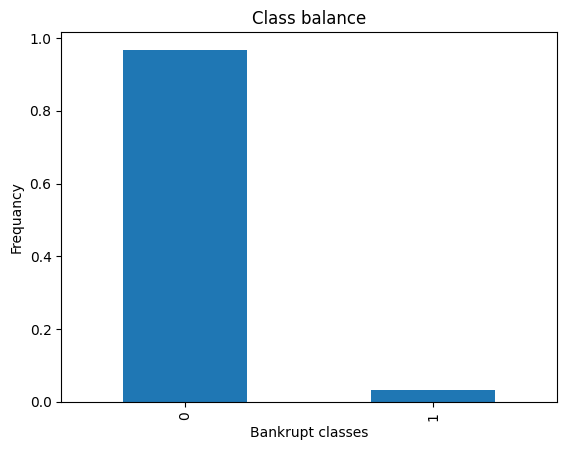

In [15]:
# Visulizing the data for instances like class imbalances

df['bankrupt'].value_counts(normalize= True).plot(kind= 'bar')
plt.xlabel("Bankrupt classes")
plt.ylabel("Frequancy")
plt.title("Class balance")
plt.savefig("class_balance.png");

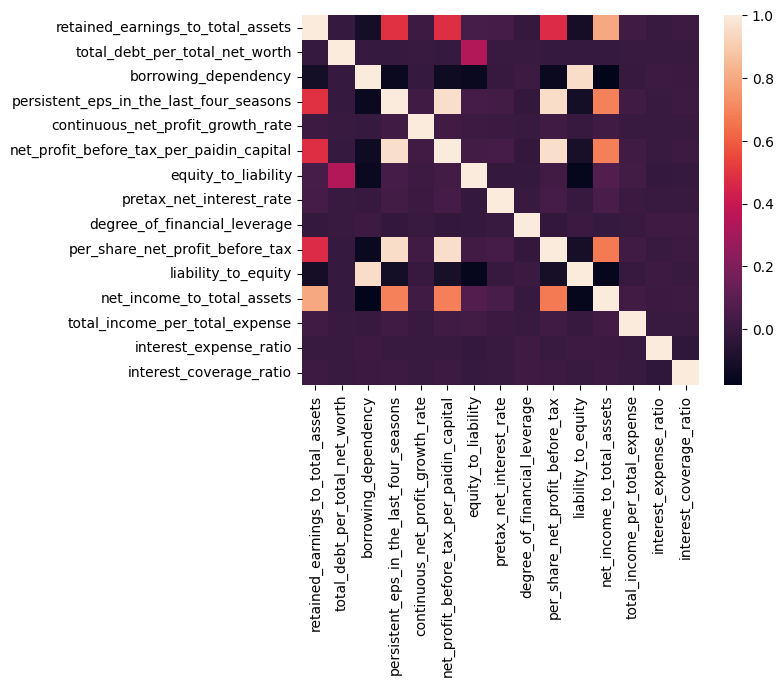

In [16]:
# Visualizing the correlation between features
corr = df.drop(columns=['bankrupt']).corr()
sns.heatmap(corr);
plt.savefig("correlation.png");

# Preparing the data for training

In [18]:
# defining a function that will split the data and handle class imbalance for the training samples

def prepare_and_resample_data(data, target='bankrupt', test_size=0.2,
                           resample_method='random_oversample', random_state=42):
    """
    Prepare data by splitting into features/target and train/test sets, then resample training data.

    Args:
        df (pd.DataFrame): The dataset
        target (str): Name of the target column (default: 'bankrupt')
        test_size (float): Proportion for test set (default: 0.2)
        resample_method (str): Resampling method ('random_oversample' or 'smote', default: 'random_oversample')
        random_state (int): Random seed (default: 42)

    Returns:
        tuple: X_train_resampled, X_test, y_train_resampled, y_test
               (If resample=False, returns X_train, X_test, y_train, y_test)
    """
    # Split into features and target
    X = data.drop(columns=[target])
    y = data[target]

    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state,
        stratify=y
    )

    # Resample the training data
    if resample_method == 'random_oversample':
        ros = RandomOverSampler(random_state=random_state)
        X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

    return X_train_resampled, X_test, y_train_resampled, y_test


In [21]:
X_train_resampled, X_test, y_train_resampled, y_test = prepare_and_resample_data(df)
X_train_resampled.shape, y_train_resampled.shape

((10558, 15), (10558,))

# Model Training

In [24]:
# Defining a function that will evaluate the trained models
def evaluate_model(model, X_test, y_test):
    """
    Evaluate model performance and print full report

    Args:
        model: Trained model
        X_test: Test features
        y_test: Test labels

    Returns:
        dict: Evaluation metrics (also prints full report)
    """
    y_pred = model.predict(X_test)

    metrics = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1_score": f1_score(y_test, y_pred)
    }

    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("\nKey Metrics:")
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")

    return metrics


In [25]:
#  Initializing and training the model
rf_basic = RandomForestClassifier(random_state=42)
rf_basic.fit(X_train_resampled, y_train_resampled)

#  Evaluating the model using the function
basic_metrics = evaluate_model(rf_basic, X_test, y_test)

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1320
           1       0.48      0.27      0.35        44

    accuracy                           0.97      1364
   macro avg       0.73      0.63      0.67      1364
weighted avg       0.96      0.97      0.96      1364


Key Metrics:
Accuracy: 0.9670
Precision: 0.4800
Recall: 0.2727
F1_score: 0.3478


# Tuning The Hyperparameters

In [26]:
# Tuning The Hyperparameters
params= {

    "n_estimators":range(25, 100, 25),
    "max_depth": range(10, 60,10)

}
params

{'n_estimators': range(25, 100, 25), 'max_depth': range(10, 60, 10)}

In [27]:
Tuned_model = GridSearchCV(

    rf_basic,
    param_grid= params,
    cv=5,
    n_jobs=-1,
    verbose= 1

)
Tuned_model

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(10, 60, 10),
                         'n_estimators': range(25, 100, 25)},
             verbose=1)

In [28]:
Tuned_model.fit(X_train_resampled , y_train_resampled)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(10, 60, 10),
                         'n_estimators': range(25, 100, 25)},
             verbose=1)

In [29]:
cv_results = pd.DataFrame(Tuned_model.cv_results_)
cv_results.sort_values('rank_test_score').head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
8,2.970385,1.133774,0.067965,0.039915,30,75,"{'max_depth': 30, 'n_estimators': 75}",0.992424,0.988636,0.994792,0.994789,0.995737,0.993276,0.002565,1
11,1.803550,0.182276,0.042357,0.012935,40,75,"{'max_depth': 40, 'n_estimators': 75}",0.991951,0.988636,0.994792,0.994315,0.995737,0.993086,0.002551,2
14,1.650253,0.099245,0.031480,0.004837,50,75,"{'max_depth': 50, 'n_estimators': 75}",0.991951,0.988636,0.994792,0.994315,0.995737,0.993086,0.002551,2
7,1.145046,0.017132,0.024252,0.000810,30,50,"{'max_depth': 30, 'n_estimators': 50}",0.990530,0.989583,0.995265,0.993842,0.995263,0.992897,0.002395,4
10,1.749080,0.132028,0.051739,0.024402,40,50,"{'max_depth': 40, 'n_estimators': 50}",0.991004,0.989583,0.995265,0.993842,0.994789,0.992897,0.002220,5
13,1.422733,0.355291,0.026158,0.002436,50,50,"{'max_depth': 50, 'n_estimators': 50}",0.991004,0.989583,0.995265,0.993842,0.994789,0.992897,0.002220,5
6,0.600683,0.024492,0.014886,0.001039,30,25,"{'max_depth': 30, 'n_estimators': 25}",0.989110,0.989110,0.992424,0.992421,0.994789,0.991571,0.002187,7
9,1.214131,0.409122,0.029990,0.008766,40,25,"{'max_depth': 40, 'n_estimators': 25}",0.989583,0.989110,0.992424,0.991947,0.994789,0.991571,0.002061,8
12,1.055843,0.075128,0.025214,0.010447,50,25,"{'max_depth': 50, 'n_estimators': 25}",0.989583,0.989110,0.992424,0.991947,0.994789,0.991571,0.002061,8
4,1.121886,0.023378,0.023456,0.001929,20,50,"{'max_depth': 20, 'n_estimators': 50}",0.985795,0.986742,0.991477,0.991473,0.992894,0.989677,0.002846,10


In [30]:
Tuned_model.best_params_

{'max_depth': 30, 'n_estimators': 75}

In [31]:
y_pred = Tuned_model.predict(X_test)

acc_train = Tuned_model.score(X_train_resampled , y_train_resampled)
acc_test = Tuned_model.score(X_test , y_test)

print(f"Training accuracy: {round(acc_train , 4)}")
print(f"test accuracy: {round(acc_test , 4)}")

Training accuracy: 1.0
test accuracy: 0.9663


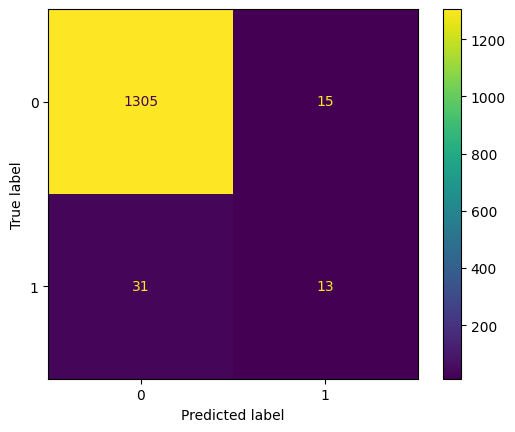

In [32]:
ConfusionMatrixDisplay.from_estimator(

    Tuned_model,
    X_test,
    y_test

);

In [33]:
#  Evaluating the tuned model using the function
Tuned_metrics = evaluate_model(Tuned_model, X_test, y_test)

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1320
           1       0.46      0.30      0.36        44

    accuracy                           0.97      1364
   macro avg       0.72      0.64      0.67      1364
weighted avg       0.96      0.97      0.96      1364


Key Metrics:
Accuracy: 0.9663
Precision: 0.4643
Recall: 0.2955
F1_score: 0.3611


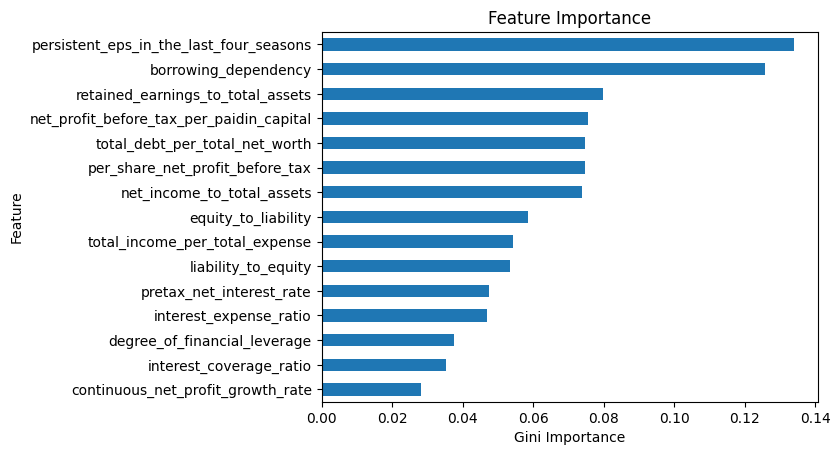

In [34]:
# Plotting the feature importances
features = X_test.columns
importances = Tuned_model.best_estimator_.feature_importances_

feat_imp = pd.Series(importances , index=features).sort_values()
feat_imp.tail(15).plot(kind= 'barh')
plt.xlabel("Gini Importance")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.savefig("feature_importances.jpg")
plt.show();

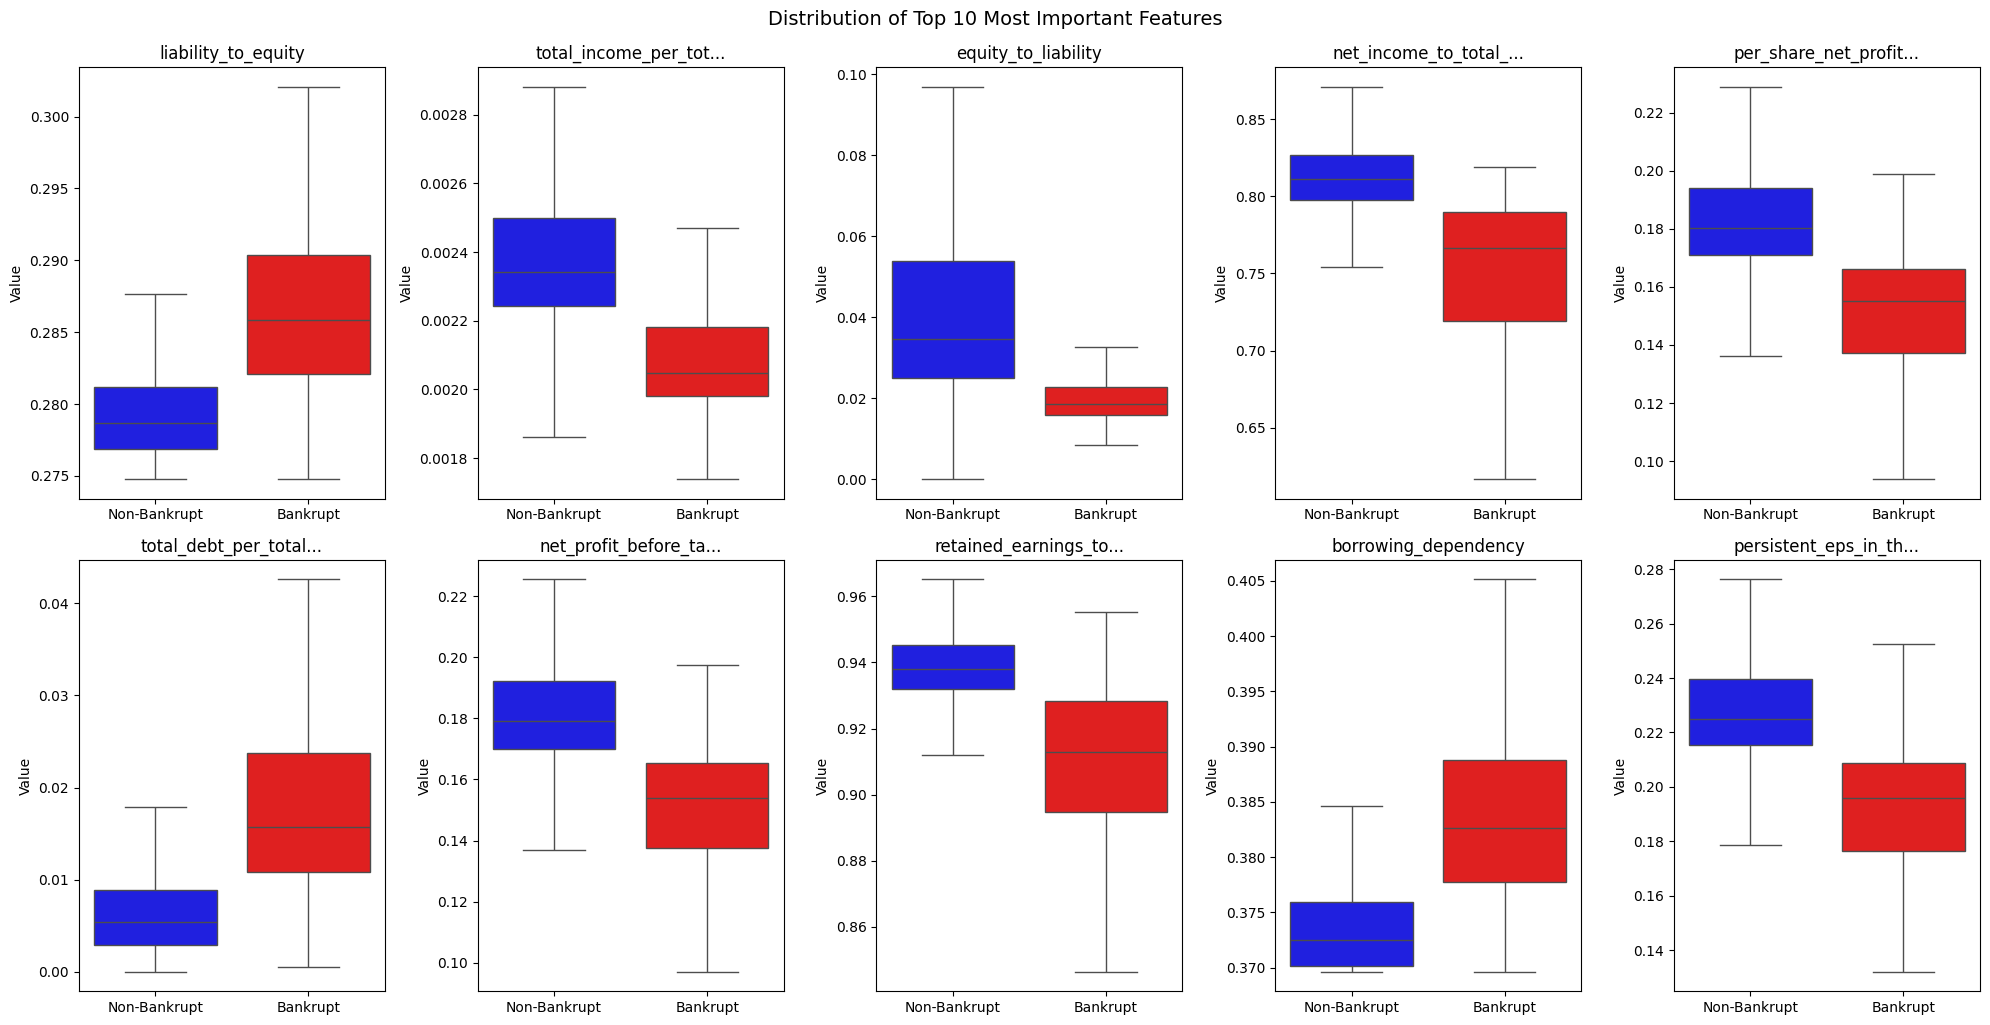

In [39]:
# Get the top 10 most important features from your existing feat_imp Series
top_features = feat_imp.tail(10).index.tolist()

# Set up the plot
plt.figure(figsize=(20, 10))

# Create boxplots for each top feature
for i, feature in enumerate(top_features, 1):
    plt.subplot(2, 5, i)
    sns.boxplot(
        x=y,
        y=df[feature],
        hue=y,
        palette={0: 'blue', 1: 'red'},
        legend=False,
        showfliers=False  # Removed outliers for cleaner visualization
    )
    plt.title(f"{feature[:20]}" + ("..." if len(feature) > 20 else ""))
    plt.xlabel("")
    plt.ylabel("Value")
    plt.xticks([0, 1], ['Non-Bankrupt', 'Bankrupt'])

plt.tight_layout()
plt.suptitle("Distribution of Top 10 Most Important Features", y=1.02, fontsize=14)
plt.savefig("top_features_boxplots.jpg", bbox_inches='tight', dpi=300)
plt.show()

In [40]:
# Save model
with open("random_classifier.pkl", "wb") as f:
    pickle.dump(Tuned_model, f)

#Summary


- The model did well in predicting bankruptcy with an accuracy of  almost 97%. However, it performs far better in predicting the negative class with a precision of 98%, a recall of 99%, and an f1 -score of 98%. When predicting the positive class, these metrics drop drastically, where the precision falls to 46%, a recall of 0.30, and an f1-score of 36%. This was due to the dataset used which had a huge class imbalance, making the model learn far better from the negative class data than it did on the positive class.

- Although we used random-oversampling to ty and balance the data, it still is not accurate as if it was real data. Attempts to use SMOTE yielded far worse results that random_oversampling, which is why it is what was leveraged in this notebook

- Another remark is the effect of the hyperparameters tuning which seemed to not improve the accuracy of the model but atleast tried to improve the recall score from 0.27 to 30, which is the most important metric if you consider the case of bankruptcy we are trying to classify. Again, the change was slight because the data did not have much complexity as it turned out, except for the class imbalance challenge only.